## Homework: FX Carry Strategy

========================================================================================================================

### Richmond Frankeberger 12277572 

========================================================================================================================

A Carry strategy is a trading strategy where one borrows in a country that has a low interest rate, and lends in another with a much higher interest rate. The idea behind a carry strategy is to take advantage of the fact that uncovered interest rate parity does not hold - in other words, FX rates will not converge in order to offset the value in the difference in interest rate between countries. Many currency pairs and yields tend to stay in disparity, however volatility in markets can cause sudden regime changes that can implode a position. The below analysis explores an example carry strategy and its effectiveness in terms of risk and diversification.

### Defining Data and Variables

========================================================================================================================

Data from Quandl will be obtained for:

UK 1M OIS rates, GBPUSD FX

YC and FX data for South Africa, Thailand, Pakistan, and the Philippines.

#### Imports, Functions and Data Download

In [1]:
%matplotlib inline
import pandas                    as     pd
import numpy                     as     np
import seaborn                   as     sns
import statsmodels.api           as     sm
import scipy
import sys
import requests
import time
import pytz
import functools
import quandl
from   matplotlib                import pyplot as plt
from   datetime                  import datetime
from   datetime                  import timedelta
from   p_tqdm                    import p_map,t_map
from   tqdm.notebook             import tqdm
from   os.path                   import exists  
quandl.ApiConfig.api_key         =      "hJrpPb7hMqbAvC9tkQZy"

In [2]:
### Download and format Fama French data. Data is available only up to November of last year.
FFFactors         = pd.read_csv(r"D:\Documents\Education\University of Chicago\Q2\Regression Analysis\HW\HW2_Fama_French_Factors.csv")
FFFactors['Date'] = pd.to_datetime(FFFactors['Date'], format='%Y%m%d', errors='ignore')
FFFactors         = FFFactors.set_index('Date')

##### Main Functions:

In [3]:
### Download GBP OIS
def OIS():
    if exists("UK_OIS.pkl"):
        UK_OIS = pd.read_pickle("UK_OIS.pkl")
    else:
        UK_OIS = quandl.get('YC/GBR_ISSC')
        UK_OIS.to_pickle("UK_OIS.pkl")
        UK_OIS = pd.read_pickle("UK_OIS.pkl")
    return UK_OIS
        
### Download FX Data
def FX(FX_list):
    newseries = pd.DataFrame()
    for fx in FX_list:
        if exists("FX_{}.pkl".format(fx)):
            newseries = pd.concat([newseries,pd.read_pickle('FX_{}.pkl'.format(fx))],1)
        else:
            store = quandl.get('CUR/{}'.format(fx)).rename(columns={'RATE':'{}'.format(fx)})
            store.to_pickle('FX_{}.pkl'.format(fx))
            newseries = pd.concat([newseries,store],1)
    return newseries

### Download YC data, otherwise parse to include only bond data (exclude notes and averages)
def YC(yc):

    if exists("YC_{}.pkl".format(yc)):
        try:
            YC = pd.read_pickle('YC_{}.pkl'.format(yc))
            YC = YC.drop(columns = YC.columns[YC.columns.str.contains('to|Month', regex=True)]).rename(columns=lambda x: x.strip('-Year'))
        except:
            YC = pd.read_pickle('YC_{}.pkl'.format(yc))
    else:
        store = quandl.get('YC/{}'.format(yc)).rename(columns={'RATE':'{}'.format(yc)}).ffill()
        store.to_pickle('YC_{}.pkl'.format(yc))
        try:
            YC = pd.read_pickle('YC_{}.pkl'.format(yc))
            YC = YC.drop(columns = YC.columns[YC.columns.str.contains('to|Month', regex=True)]).rename(columns=lambda x: x.strip('-Year'))
        except:
            YC = pd.read_pickle('YC_{}.pkl'.format(yc))

    return YC

### Filter data to include only Wednesdays
def Wednesdays(df):
    df         = df[df.index.dayofweek == 2]
    return df

### Change index to int type for the compute_zcb_curve function
def indexint(df):
    df.index   = df.index.astype(int)
    return df

### Directly from the Zero and Spot Curves file in the class material
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
                
    return zcb_rates


def performanceMetrics(returns, annualization = 1):
    df = returns.copy()
    q = 0.05
    metrics            = pd.DataFrame(index=returns.columns)
    metrics['Mean']    = returns.mean() * annualization
    metrics['Vol']     = returns.std() * np.sqrt(annualization)
    metrics['Sharpe']  = (returns.mean() / returns.std()) * np.sqrt(annualization)
    metrics['Sortino'] = (returns.mean() / returns[returns < 0].std()) * np.sqrt(annualization)
    metrics['Min']     = returns.min()
    metrics['Max']     = returns.max()
    metrics.sort_values('Sharpe',ascending = False)
    
    # return metrics
    
    report = pd.DataFrame(columns = df.columns)
    
    #report.loc['Skewness'] = df.skew()
    #report.loc['Excess Kurtosis'] = df.kurtosis()
    #report.loc['VaR (Quantile {})'.format(q)] = df.quantile(q)
    #report.loc['VaR (Normal)'] = df.mean() + scipy.stats.norm().ppf(q) * df.std()
    #report.loc['Expected Shortfall'] = df[df < df.quantile(q)].mean()
    #report.loc['Expected Shortfall (Normal)'] = df.mean() - scipy.stats.norm.pdf((scipy.stats.norm().ppf(q)))/q * df.std()
    
    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    report.loc['Max Drawdown'] = drawdown.min()
    
    report.loc['MDD Start'] = None
    report.loc['MDD End'] = drawdown.idxmin()
    report.loc['Recovery Date'] = None
    report.loc['Single Largest Drawdown']        = df.min()
    report.loc['Single Largest Drawdown Date']   = df.idxmin()
    
    for col in df.columns:
        report.loc['MDD Start', col] = (rolling_max.loc[:report.loc['MDD End', col]])[col].idxmax()
        recovery_df = (drawdown.loc[report.loc['MDD End', col]:])[col]
        # modify the threshold for recovery from 0 to 0.001
        try:
            report.loc['Recovery Date', col] = recovery_df[recovery_df >= 0].index[0]
            report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['MDD Start']).dt.days

        except:
            report.loc['Recovery Date', col] = None
            report.loc['Recovery period (days)'] = None
    
    return pd.concat([metrics,report.T],1)

def corr(df, self_corr = None):
    corrmat = df.corr() 
    corrmat[corrmat==1] = self_corr
    ax = plt.axes()
    sns.heatmap(corrmat,annot=True,cmap='Blues')
    ax.set_title('Correlation of Strategy vs. Fama-French Factors')
    
### Run OLS regressions and report data in annualized terms

def OLSIntercept(y,x,ann=12):
    myx = sm.add_constant(x)
    OLS = sm.OLS(y,myx,missing='drop').fit()
    TE  = OLS.resid.std() * np.sqrt(ann)
    return ('Beta:',(OLS.params[1:])),('Alpha (Ann): {:.5f} R-Squared: {:.5f} Tracking Error: {:.5f}'.format(OLS.params['const']*ann,OLS.rsquared,TE))

def OLSNOIntercept(y,x,ann=12):
    myx = x
    OLS = sm.OLS(y,myx,missing='drop').fit()
    TE  = OLS.resid.std() * np.sqrt(ann)
    return ('Beta:',(OLS.params[:])),('R-Squared: {:.5f} Tracking Error: {:.5f}'.format(OLS.rsquared,TE))

##### Define key variables and datasets:

In [4]:
FX_list = ['GBP','PHP','ZAR','THB','PKR']
YC_list = ['PHL','ZAF','THA','PAK']

As discussed in office hours on 2/13, a. notes will not be included in interpolation, and b. for ZAF, 10year will be interpreted as the 5 year spot curve.

Data below is cleaned to: Include only Wednesdays, convert yields to percentage terms, and change object types to be compatible with the provided compute_zcb_curve function.

In [5]:
PHL_YC  = indexint((YC(YC_list[0])/100).T) # bonds are semiannual, notes are quarterly   https://www.pnb.com.ph/index.php/investment-opportunities/treasury-bonds
ZAF_YC  = indexint((YC(YC_list[1])/100).T) # bonds are semiannual                        http://www.treasury.gov.za/comm_media/press/2002/2002121301.pdf
THA_YC  = indexint((YC(YC_list[2])/100).T) # bonds are semiannual                        https://www.bot.or.th/English/DebtSecurities/IntroToGovtDebtSecurities/Pages/Type.aspx
PAK_YC  = indexint((YC(YC_list[3])/100).T) # bonds are semiannual, notes are zero-coupon https://www.finance.gov.pk/publications/PIB_Guide.pdf ,                                https://www.finance.gov.pk/publications/MTB_Guide.pdf

In [6]:
ZAF_YC  = ZAF_YC.rename(index={10:5})

In [7]:
GBPOIS  = Wednesdays(OIS()[['0.08Y']])/100
FXRates = Wednesdays(FX(FX_list))

Convert from Treasury Curve to ZC curve, and retrieve the 5y rate for PL calculation. At this point, YC data will be forward filled for missing points up to one month/21 days (PAK and ZAF data is stale after Q120 and Q420 respectively, so it is better to not forward fill stale prices for any extended period of time). After this operation, data is converted to include only Wednesdays.

Section 4 of the assignment asks to use quarterly coupon 5Y swap rates, or the 5Y treasury rate. Since only 5Y treasury rates are readily available, the analysis will be done using the 5Y semiannual coupon yield curves.

In [8]:
PHL_YC_Zero = (compute_zcb_curve(PHL_YC).T).loc[:,[5]]
ZAF_YC_Zero = (compute_zcb_curve(ZAF_YC).T).loc[:,[5]]
THA_YC_Zero = (compute_zcb_curve(THA_YC).T).loc[:,[5]]
PAK_YC_Zero = (compute_zcb_curve(PAK_YC).T).loc[:,[5]]
AllCurves   = Wednesdays(pd.concat([PHL_YC_Zero,ZAF_YC_Zero,THA_YC_Zero,PAK_YC_Zero],1).ffill(limit=21))
AllCurves.columns = ['PHL','ZAF','THA','PAK']

Although GBPOIS is available from 2009-2022, and FX rates are available all the way back from 2000, yield curve data is only available as far back as 2014 for PHL. This will define the timeframe for the PL strategy analysis, i.e. begin investing when the first yield curve is available, and from there choose the best opportunity.

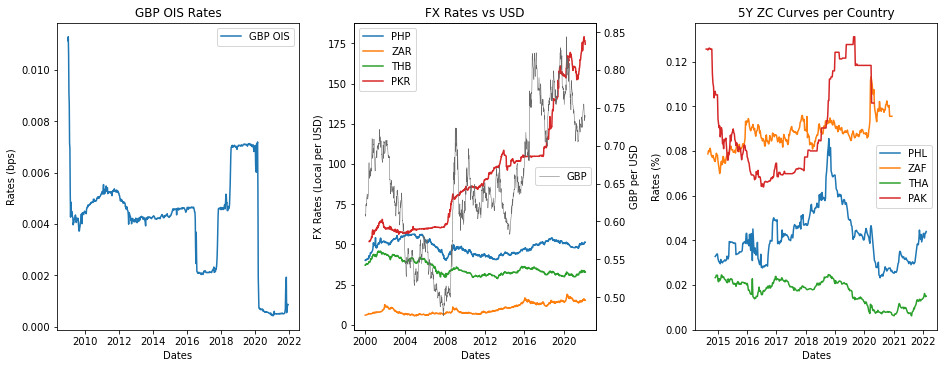

In [9]:
fig1, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,5),constrained_layout=True)
axg = ax2.twinx()
l1 = ax1.plot(GBPOIS.index,GBPOIS,label="GBP OIS")
l2 = ax2.plot(FXRates.index,FXRates.iloc[:,1:])
lg = axg.plot(FXRates.index,FXRates.iloc[:,0],'dimgrey',linewidth=0.5)
l3 = ax3.plot(AllCurves.index,AllCurves)
ax1.legend(loc = 'upper right');                                ax1.title.set_text("GBP OIS Rates"); ax1.set_xlabel('Dates'); ax1.set_ylabel('Rates (bps)')
ax2.legend([i for i in FXRates.columns[1:]], loc = 'upper left');   ax2.title.set_text("FX Rates vs USD");      ax2.set_xlabel('Dates'); ax2.set_ylabel('FX Rates (Local per USD)'); axg.set_ylabel('GBP per USD'); axg.legend(['GBP'],loc='center right')
ax3.legend(['PHL','ZAF','THA','PAK'],    loc = 'center right'); ax3.title.set_text("5Y ZC Curves per Country"); ax3.set_xlabel('Dates'); ax3.set_ylabel('Rates (%)')
plt.show()

Given ZAF is the highest interest rate at the point in time its data becomes available, this will interfere with proper PL calculation given forward data will not be available. This can be alleviated by overriding the best carry currency on the date.

========================================================================================================================

### Strategy Implementation

========================================================================================================================

The details of the strategy are as follows:

\\$2m in capital will be levered 5x by borrowing GBP with weekly resets. The \\$10m total cash at hand will be invested evenly across countries for which data on both yield curves and fx exists, and where there is at least a 50bp spread between the GBP OIS rate and the local yield. The borrowed cash will be converted at the prevailing FX rate from GBP to USD, and all USD at hand will be converted at the prevailing FX rates to local currencies. The local cash will be lent out at the 5y rate for a duration of one week. In terms of day count convention, the PB Fee for borrowing GBP will be Act/365, and Bond MtM will be on a 1/52 basis (as discussed in the lecture video).

In [10]:
### Assumes that first fx rate in fx_list is the borrow rate fx. PL is calculated on the start date row, therefore last row in the dataset will have no PL
def FX_Carry(K,lev_ratio,borrow_rate,fx_list,YC_list):
    ### Start at 2014, where there is enough data to potentially execute a carry strategy
    strat                      = pd.concat([borrow_rate,fx_list,YC_list],1).dropna(thresh=8)
    strat.iloc[:,0]            = strat.iloc[:,0].ffill()
    strat['exit']              = strat.index.shift(7,freq='D')
    strat['Borrow_Rate']       = strat.iloc[:,0] + 0.0050
    strat['Borrow_FX_Exit']    = strat.iloc[:,1].shift(-1)
    for f in fx_list.columns[1:]:
        strat['{}_Curve_FX_Exit'.format(f)] = strat[f].shift(-1) 
    for y in YC_list.columns:
        strat['{}_Curve_Exit'.format(y)] = strat[y].shift(-1)
    
    ### Check if the spread is over 50bps, i.e. risk-reward ratio is good enough to invest. For this dataset, should always be the case.
    for pf in YC_list.columns:
        strat['Pos_Flag_{}'.format(pf)]  = np.where(strat['Borrow_Rate'] < strat[pf] - 0.0050,1,0)
        
    strat['Pos_Flag_TTL'] = strat[strat.columns[strat.columns.str.contains('Pos_Flag')]].eq(1).sum(axis=1)
    
    ### Calculate Borrow PL here. Calculate PB Fee based on actual/365 accrual
    strat['Borrow_MtM_Local']  = ((K * lev_ratio) - K) * fx_list.iloc[:,0] * strat['Borrow_Rate'] * (strat.index - strat['exit']).dt.days / 365
    strat['Borrow_MtM_Base']   = (strat['Borrow_MtM_Local'] / (strat['Borrow_FX_Exit'])).fillna(0)
    strat['Borrow_Ntnl_FXPL']  = ( ((K * lev_ratio) - K) * (((1/strat['Borrow_FX_Exit'])/(1/strat.iloc[:,1]) - 1) )).fillna(0)
    
    matchfxyc = dict(zip(AllCurves.columns,FXRates.columns[1:]))
    
    ### Calculate Lending PL here.
    for l in YC_list.columns:
        strat['Lend_MtM_Local_{}'.format(l)] = (((((K * lev_ratio / strat['Pos_Flag_TTL']) * strat[matchfxyc[l]]) * (np.exp(-strat['{}_Curve_Exit'.format(l)] * (4 + 51/52)) / np.exp(-strat[l] * 5))) - ((K * lev_ratio / strat['Pos_Flag_TTL']) * strat[matchfxyc[l]])) * strat['Pos_Flag_{}'.format(l)]).fillna(0).round(2)
    for l in YC_list.columns:
        strat['Lend_MtM_Base_{}'.format(l)] = (strat['Lend_MtM_Local_{}'.format(l)] / strat['{}_Curve_FX_Exit'.format(matchfxyc[l])]).fillna(0)
    for l in YC_list.columns:    
        strat['Lend_Ntnl_FXPL_{}'.format(l)]    = (( ((K * lev_ratio / strat['Pos_Flag_TTL'])) * ((1/strat['{}_Curve_FX_Exit'.format(matchfxyc[l])])/(1/strat[matchfxyc[l]])-1) ) * strat['Pos_Flag_{}'.format(l)]).fillna(0)

    ### Aggregate PL here.
    strat['PL_Carry_WTD']      = strat['Borrow_MtM_Base'] + strat[strat.columns[strat.columns.str.contains('Lend_MtM_Base')]].sum(axis=1)
    strat['PL_FX_WTD']         = strat['Borrow_Ntnl_FXPL'] + strat[strat.columns[strat.columns.str.contains('Lend_Ntnl_FXPL')]].sum(axis=1)
    strat['PL_WTD']            = strat['PL_Carry_WTD'] + strat['PL_FX_WTD']
    strat['Return_WTD']        = ((strat['PL_WTD'] + (K * lev_ratio))/(K * lev_ratio) - 1)
    strat['PL_Carry_LTD']      = strat['PL_Carry_WTD'].cumsum().round(2)
    strat['PL_FX_LTD']         = strat['PL_FX_WTD'].cumsum().round(2)
    strat['PL_LTD']            = strat['PL_WTD'].cumsum().round(2)
    strat['Return_LTD']        = (1+strat['Return_WTD']).cumprod() - 1

    return strat

========================================================================================================================

### Strategy Performance

========================================================================================================================

Overall, the strategy makes money over the 7 years from 2014 to 2021. There is a significant offset in the PL between pull to par and FX PL - this should be expected as Mark-to-Market from yield accumulation is the carry strategy itself - and FX is the risk from uncovered interest rate parity oscillating between parity and disparity throughout the investment period (disparity is favorable for the carry trade).

The life-to-date (LTD) returns in USD for the strategy is \\$1.1m, or 5\% in cumulative compounded returns.

#### Strategy PL and Performance Metrics

In [11]:
results_main = FX_Carry(2000000,5,GBPOIS,FXRates,AllCurves)
results_main.iloc[[-1],-4:]

,PL_Carry_LTD,PL_FX_LTD,PL_LTD,Return_LTD
2021-12-08,4364199.3,-3270689.37,1093509.93,0.05059


#### Annualized Risk Metrics

The Sharpe and Sortino ratios are particularly low for the carry trade - generally a carry trade should have a Sharpe/Sortino of at least 0.5 to 1.0, but here it is only 12%/16% respectively. The Max Drawdown is 25% and takes almost 3 years to recover - and visually it can be seen that the strategy LTD PL is negative most of the time.

In [12]:
perf_main = performanceMetrics(results_main[['Return_WTD']],52)
perf_main

,Mean,Vol,Sharpe,Sortino,Min,Max,Max Drawdown,MDD Start,MDD End,Recovery Date,Single Largest Drawdown,Single Largest Drawdown Date,Recovery period (days)
Return_WTD,0.015083,0.128334,0.117528,0.160395,-0.109415,0.053184,-0.246959,2018-04-11,2020-03-18,2020-11-04,-0.109415,2020-03-11,938


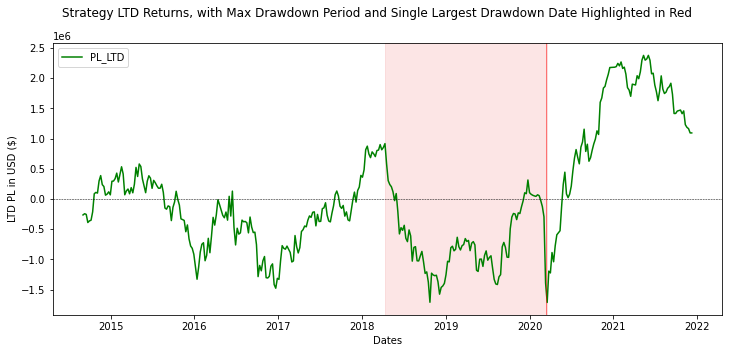

In [33]:
fig, ax1 = plt.subplots(figsize = (12,5))
fig.suptitle('Strategy LTD Returns, with Max Drawdown Period and Single Largest Drawdown Date Highlighted in Red')
ax1.plot(results_main[['PL_LTD']],'g')
ax1.legend(['PL_LTD'],loc = 'upper left')
plt.axvspan(['2018-04-11'], ['2020-03-18'], color='lightcoral', alpha=0.2)
plt.axvline(x=['2020-03-11'], color='red', linestyle='-',linewidth=0.5)
plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)
ax1.set_xlabel('Dates')
ax1.set_ylabel('LTD PL in USD ($)')
plt.show()

#### FX vs Carry through Time

The below chart shows how FX is always a negative factor in the strategy calculation, while carry always contributes positive PL, on an accumulated basis. The drawdowns are due to sharp fluctuations in the FX rate as well - most probably due to sharp depreciation in the currency the strategy lends in.

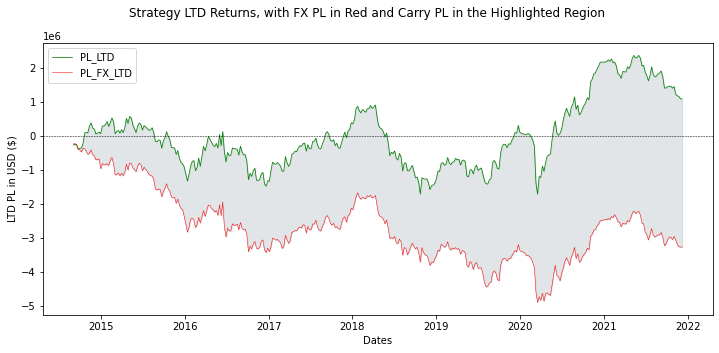

In [14]:
fig, ax1 = plt.subplots(figsize = (12,5))
fig.suptitle('Strategy LTD Returns, with FX PL in Red and Carry PL in the Highlighted Region')
ax1.plot(results_main[['PL_LTD']],'g',linewidth=0.75)
ax1.plot(results_main[['PL_FX_LTD']],'r',linewidth=0.5)
ax1.legend(['PL_LTD','PL_FX_LTD'],loc = 'upper left')
plt.fill_between(results_main[['PL_LTD']].index,results_main['PL_LTD'],results_main['PL_FX_LTD'],color='slategray',alpha=0.2)
plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)
ax1.set_xlabel('Dates')
ax1.set_ylabel('LTD PL in USD ($)')
plt.show()

#### Contribution per Country

The below table and graph illustrate the carry performance of the strategy broken down by country invested in. Pakistan contributes the most Carry PL, though this is largely offset by FX depreciation. South Africa is the best performer overall. Thailand is the only country where the FX appreciates, however the interest rate is low compared to other countries, so overall contribution is small.

In [15]:
results_FX = results_main.sum()[['Lend_Ntnl_FXPL_PHL','Lend_Ntnl_FXPL_ZAF','Lend_Ntnl_FXPL_THA','Lend_Ntnl_FXPL_PAK']]
results_Carry = results_main.sum()[['Lend_MtM_Base_PHL','Lend_MtM_Base_ZAF','Lend_MtM_Base_THA','Lend_MtM_Base_PAK']]
result_ind = ['PHL','ZAF','THA','PAK']

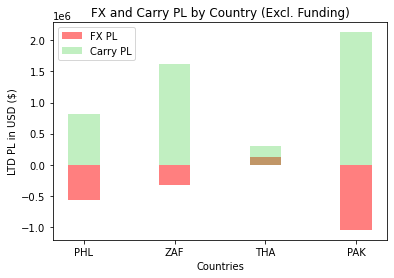

In [16]:
width = 0.35
fig = plt.figure()
ax = plt.subplot(111)
ax.bar(result_ind, results_FX, width, color='r',alpha=0.5)
ax.bar(result_ind, results_Carry, width, color='limegreen',alpha=0.3)
ax.set_ylabel('LTD PL in USD ($)')
ax.set_xlabel('Countries')
ax.set_title('FX and Carry PL by Country (Excl. Funding)')
ax.legend(labels=['FX PL', 'Carry PL'])
plt.show()

In [17]:
pd.set_option('display.max_columns', None)

The below graph shows PL over time. It can be seen that the trades generally trend upwards, with periods of sharp downturn. The downturn for ZAF during Q120 during COVID is the most notable.

It is also noted that most of the carry PL is actually positive, and the losses of the strategy are generally accumulated from having borrowed in GBP.

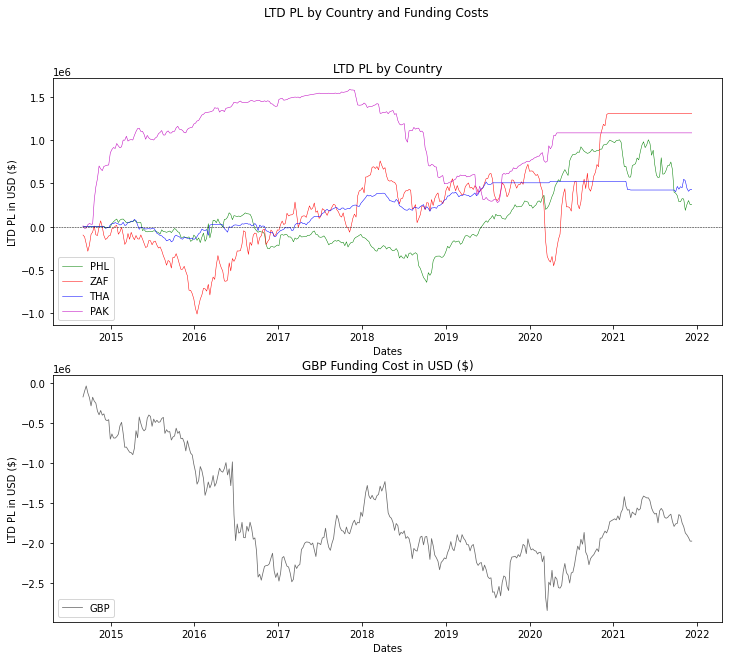

In [18]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize = (12,10))
fig.suptitle('LTD PL by Country and Funding Costs'); ax1.set_title('LTD PL by Country'); ax2.set_title('GBP Funding Cost in USD ($)')
ax1.plot((results_main['Lend_Ntnl_FXPL_PHL']+results_main['Lend_MtM_Base_PHL']).cumsum(),'g',linewidth=0.5)
ax1.plot((results_main['Lend_Ntnl_FXPL_ZAF']+results_main['Lend_MtM_Base_ZAF']).cumsum(),'r',linewidth=0.5)
ax1.plot((results_main['Lend_Ntnl_FXPL_THA']+results_main['Lend_MtM_Base_THA']).cumsum(),'b',linewidth=0.5)
ax1.plot((results_main['Lend_Ntnl_FXPL_PAK']+results_main['Lend_MtM_Base_PAK']).cumsum(),'m',linewidth=0.5)
ax1.axhline(y=0,color='black',linestyle='--',linewidth=0.5)
ax2.plot((results_main['Borrow_Ntnl_FXPL']+results_main['Borrow_MtM_Base']).cumsum(),'dimgrey',linewidth=0.75)
ax1.legend(['PHL','ZAF','THA','PAK'],loc = 'lower left'); ax2.legend(['GBP'],loc='lower left')
ax1.set_xlabel('Dates'); ax2.set_xlabel('Dates'); ax1.set_ylabel('LTD PL in USD ($)'); ax2.set_ylabel('LTD PL in USD ($)')
plt.show()

#### Diversification: Beta and Correlation with Fama-French

The carry strategy has some notable beta to the market at 20%, although $R^2$ is only about 8%. The downside beta is not much more pronounced - beta remains at around 22%, and $R^2$ falls slightly, though still around 8%. There is no large impact in including an intercept or not - the mean of the strategy is expected to be around zero. The main conclusion from analyzing betas is that the downside beta is not too different from beta itself - that means that the variability of the returns with the market is consistent even during periods of stress.

Generally speaking, the strategy exhibits some surprisingly high correlation with the market at 0.28 - so may not be as diversifying as one would predict. (By diversifying across different countries and currencies, it would have been preferable to have as low (near zero) a correlation as possible to the market.) Of course, the data is based on weekly data for which there aren't many datapoints - the correlation may be highly reflective of how correlations go up in times of market stress, which would also be related to FX movements that directly affect the strategy PL.

In [19]:
### Reduce Fama French data period
FFFactors      = FFFactors.loc['2014-08':,:] / 100
### Reconfigure to weekly returns
FFFactors_Wkly = (FFFactors + 1).rolling(5).apply(np.prod,raw = True) - 1
### Include only Wednesdays
FFFactors_Wkly = FFFactors_Wkly[FFFactors_Wkly.index.dayofweek == 2]
### Reduce to population of Returns dataset
FFFactors_Wkly = FFFactors_Wkly.loc['2014-09-03':,:]

In [20]:
results_FF = pd.concat([results_main[['Return_WTD']],FFFactors_Wkly],1).dropna()

##### Beta

In [21]:
OLSIntercept(results_FF['Return_WTD'],results_FF.iloc[:,1:],52)

(('Beta:',
  Mkt-RF    0.202408
  SMB       0.019352
  HML       0.071798
  RF       -1.259500
  dtype: float64),
 'Alpha (Ann): -0.00296 R-Squared: 0.08480 Tracking Error: 0.12297')

In [22]:
OLSNOIntercept(results_FF['Return_WTD'],results_FF.iloc[:,1:],52)

(('Beta:',
  Mkt-RF    0.202132
  SMB       0.019335
  HML       0.071847
  RF       -1.422432
  dtype: float64),
 'R-Squared: 0.08513 Tracking Error: 0.12297')

##### Downside Beta

In [23]:
main_downside_beta = results_FF[results_FF['Mkt-RF'] + results_FF['RF'] < 0]
main_downside_beta = results_FF.assign(Market = results_FF['Mkt-RF'] + results_FF['RF'])

In [24]:
OLSIntercept(main_downside_beta['Return_WTD'],main_downside_beta['Market'])

(('Beta:',
  Market    0.216899
  dtype: float64),
 'Alpha (Ann): -0.00468 R-Squared: 0.07802 Tracking Error: 0.05929')

In [25]:
OLSNOIntercept(main_downside_beta['Return_WTD'],main_downside_beta['Market'])

(('Beta:',
  Market    0.214448
  dtype: float64),
 'R-Squared: 0.07789 Tracking Error: 0.05929')

##### Correlation

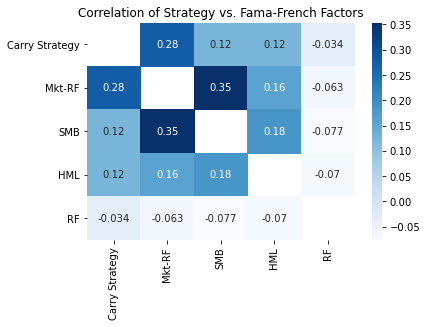

In [26]:
data_spread_FF_comp = pd.concat([results_main[['Return_WTD']].rename(columns={'Return_WTD':'Carry Strategy'}),FFFactors_Wkly],axis=1)
corr(data_spread_FF_comp)

#### Skew and Kurtosis

Given the strategy is based on weekly returns, there is room to be concerned whether any statistical analysis on the observations can be interpretable or not. Based on the below, the variance of the skew for the dataset encompasses the negative skew term of the dataset itself.
Basically, the carry strategy has negative skew and positive excess kurtosis as would be expected, however the confidence interval of the skew is so wide that it is difficult to conclude that this behavior will always be exhibited.

$skew_\Phi \sim \text{N}\left(0,\frac{6}{\sqrt{N}}\right) $

In [27]:
print("Skew is {}".format(results_main['Return_WTD'].skew()))
print("Kurtosis is {}".format(results_main['Return_WTD'].kurtosis()))
print("Skew is normally distributed with variance {}".format(6/np.sqrt(results_main.shape[0])))
print("The confidence interval of the skew is {},{}".format(-1.96*6/np.sqrt(results_main.shape[0]),1.96*6/np.sqrt(results_main.shape[0])))

Skew is -0.5773331088495401
Kurtosis is 3.9703340069178177
Skew is normally distributed with variance 0.3090157215747628
The confidence interval of the skew is -0.6056708142865351,0.6056708142865351


#### Alternative Strategy

What if we were to invest the \\$10M only in the highest yielding carry country in any given week?

Based on the below, this strategy is clearly more profitable, netting $7m over the same timeframe. The Sharpe and Sortino ratios are about 0.5 and 0.7 respectively - which is much closer to what should be expected for a normal carry trade.

One would usually think that investing in only one carry trade would be more risky - however in terms of diversification, an analysis of beta, downside beta, and correlation shows that the alternative strategy is in many ways less risky than that of the evenly spread trade.

Market beta and downside market beta are slightly lower at around 18% and 19% respectively, compared to the original strategy of 20%/22%. Correlation with the market is only 15% - half of the 28% above. The alternative strategy suffers a similar max drawdown. One other significant risk would be to consider credit risk from holding only a given country's credit at any week - but then again these are all EM countries and can be considered evenly risky. At the very least, these betas and correlations seem to reinforce such a way of thinking.

In [35]:
### Assumes that first fx rate in fx_list is the borrow rate fx. PL is calculated on the start date row, therefore last row in the dataset will have no PL
def FX_Carry_Max(K,lev_ratio,borrow_rate,fx_list,YC_list):
    ### Start at 2014, where there is enough data to potentially execute a carry strategy
    strat                      = pd.concat([borrow_rate,fx_list,YC_list],1).dropna(thresh=8)
    strat.iloc[:,0]            = strat.iloc[:,0].ffill()
    strat['exit']              = strat.index.shift(7,freq='D')
    strat['Borrow_Rate']       = strat.iloc[:,0] + 0.0050
    strat['Borrow_FX_Exit']    = strat.iloc[:,1].shift(-1)
    strat['Max_Curve']         = strat[YC_list.columns].max(axis=1)
    strat['Max_Country']       = strat[YC_list.columns].idxmax(axis=1)
    ### Manual overrides for unavailable ZAR YC data from 2020Q4 - override to PHL, the next best curve
    strat.loc['2020-12-09','Max_Country'] = 'PHL'
    strat.loc['2020-12-09','Max_Curve'] = strat.loc['2020-12-09','PHL']
    strat['Max_Curve_Exit']    = np.where(strat['Max_Country'] == YC_list.columns[0],strat[YC_list.columns[0]].shift(-1),
                                   np.where(strat['Max_Country'] == YC_list.columns[1],strat[YC_list.columns[1]].shift(-1),
                                     np.where(strat['Max_Country'] == YC_list.columns[2],strat[YC_list.columns[2]].shift(-1),
                                       np.where(strat['Max_Country'] == YC_list.columns[3],strat[YC_list.columns[3]].shift(-1),0))))
    strat['Max_Curve_FX']      = np.where(strat['Max_Country'] == YC_list.columns[0],strat[fx_list.columns[1]],
                                   np.where(strat['Max_Country'] == YC_list.columns[1],strat[fx_list.columns[2]],
                                     np.where(strat['Max_Country'] == YC_list.columns[2],strat[fx_list.columns[3]],
                                       np.where(strat['Max_Country'] == YC_list.columns[3],strat[fx_list.columns[4]],0))))
    strat['Max_Curve_FX_Exit'] = np.where(strat['Max_Country'] == YC_list.columns[0],strat[fx_list.columns[1]].shift(-1),
                                   np.where(strat['Max_Country'] == YC_list.columns[1],strat[fx_list.columns[2]].shift(-1),
                                     np.where(strat['Max_Country'] == YC_list.columns[2],strat[fx_list.columns[3]].shift(-1),
                                       np.where(strat['Max_Country'] == YC_list.columns[3],strat[fx_list.columns[4]].shift(-1),0))))

    ### Check if the spread is over 50bps, i.e. risk-reward ratio is good enough to invest. For this dataset, should always be the case.
    strat['Pos_Flag']          = np.where(strat['Borrow_Rate'] < strat['Max_Curve'] - 0.0050,'Yes','No')
    
    ### Calculate PB Fee based on actual/365 accrual
    strat['Borrow_MtM_Local']  = ((K * lev_ratio) - K) * fx_list.iloc[:,0] * strat['Borrow_Rate'] * (strat.index - strat['exit']).dt.days / 365
    strat['Borrow_MtM_Base']   = (strat['Borrow_MtM_Local'] / (strat['Borrow_FX_Exit'])).fillna(0)
    strat['Borrow_Ntnl_FXPL']  = ( ((K * lev_ratio) - K) * (((1/strat['Borrow_FX_Exit'])/(1/strat.iloc[:,1]) - 1) )).fillna(0)
    strat['Lend_MtM_Local']    = ((((K * lev_ratio) * strat['Max_Curve_FX']) * (np.exp(-strat['Max_Curve_Exit'] * (4 + 51/52)) / np.exp(-strat['Max_Curve'] * 5))) - ((K * lev_ratio) * strat['Max_Curve_FX']))
    strat['Lend_MtM_Local']    = strat['Lend_MtM_Local'].fillna(0).round(2)
    strat['Lend_MtM_Base']     = (strat['Lend_MtM_Local'] / strat['Max_Curve_FX_Exit']).fillna(0)
    strat['Lend_Ntnl_FXPL']    = ( ((K * lev_ratio)) * ((1/strat['Max_Curve_FX_Exit'])/(1/strat['Max_Curve_FX'])-1) ).fillna(0)
    strat['PL_Carry_DLY']      = strat['Borrow_MtM_Base'] + strat['Lend_MtM_Base']
    strat['PL_FX_DLY']         = strat['Borrow_Ntnl_FXPL'] + strat['Lend_Ntnl_FXPL']
    strat['PL_DLY']            = strat['Borrow_MtM_Base'] + strat['Borrow_Ntnl_FXPL'] + strat['Lend_MtM_Base'] + strat['Lend_Ntnl_FXPL']
    strat['Return_WTD']        = ((strat['PL_DLY'] + (K * lev_ratio))/(K * lev_ratio) - 1)
    strat['PL_Carry_LTD']      = strat['PL_Carry_DLY'].cumsum().round(2)
    strat['PL_FX_LTD']         = strat['PL_FX_DLY'].cumsum().round(2)
    strat['PL_LTD']            = strat['PL_DLY'].cumsum().round(2)
    strat['Return_LTD']        = (1+strat['Return_WTD']).cumprod() - 1
    
    return strat

In [29]:
pd.set_option('display.max_columns', None)

In [37]:
results_alt = FX_Carry_Max(2000000,5,GBPOIS,FXRates,AllCurves)

In [38]:
results_alt.iloc[[-1],-4:]

,PL_Carry_LTD,PL_FX_LTD,PL_LTD,Return_LTD
2021-12-08,8603913.35,-1594957.45,7008955.9,0.730984


In [40]:
perf_alt = performanceMetrics(results_alt[['Return_WTD']],52)
perf_alt

,Mean,Vol,Sharpe,Sortino,Min,Max,Max Drawdown,MDD Start,MDD End,Recovery Date,Single Largest Drawdown,Single Largest Drawdown Date,Recovery period (days)
Return_WTD,0.096675,0.205078,0.471407,0.692934,-0.10413,0.100591,-0.406893,2018-03-21,2019-08-14,2020-11-04,-0.10413,2019-05-15,959


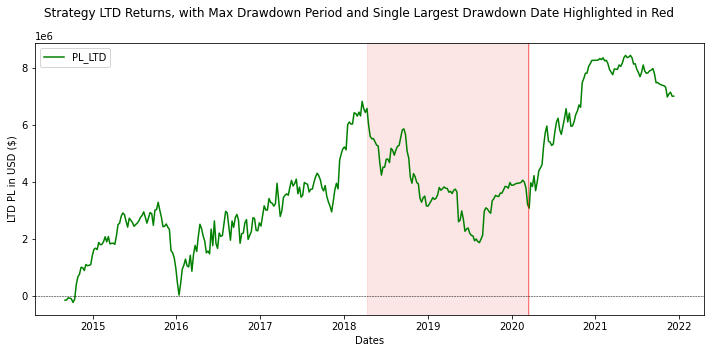

In [42]:
fig, ax1 = plt.subplots(figsize = (12,5))
fig.suptitle('Strategy LTD Returns, with Max Drawdown Period and Single Largest Drawdown Date Highlighted in Red')
ax1.plot(results_alt[['PL_LTD']],'g')
ax1.legend(['PL_LTD'],loc = 'upper left')
plt.axvspan(['2018-04-11'], ['2020-03-18'], color='lightcoral', alpha=0.2)
plt.axvline(x=['2020-03-11'], color='red', linestyle='-',linewidth=0.5)
plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)
ax1.set_xlabel('Dates')
ax1.set_ylabel('LTD PL in USD ($)')
plt.show()

In [43]:
results_FF_alt = pd.concat([results_alt[['Return_WTD']],FFFactors_Wkly],1).dropna()

##### Beta

In [44]:
OLSIntercept(results_FF_alt['Return_WTD'],results_FF_alt.iloc[:,1:],52)

(('Beta:',
  Mkt-RF    0.170352
  SMB       0.020247
  HML       0.064006
  RF       -9.633387
  dtype: float64),
 'Alpha (Ann): 0.14385 R-Squared: 0.02844 Tracking Error: 0.20322')

In [45]:
OLSNOIntercept(results_FF_alt['Return_WTD'],results_FF_alt.iloc[:,1:],52)

(('Beta:',
  Mkt-RF    0.183786
  SMB       0.021055
  HML       0.061648
  RF       -1.719412
  dtype: float64),
 'R-Squared: 0.02722 Tracking Error: 0.20346')

##### Downside Beta

In [46]:
alt_downside_beta = results_FF_alt[results_FF['Mkt-RF'] + results_FF_alt['RF'] < 0]
alt_downside_beta = results_FF_alt.assign(Market = results_FF_alt['Mkt-RF'] + results_FF_alt['RF'])

In [47]:
OLSIntercept(alt_downside_beta['Return_WTD'],alt_downside_beta['Market'])

(('Beta:',
  Market    0.187326
  dtype: float64),
 'Alpha (Ann): 0.01475 R-Squared: 0.02262 Tracking Error: 0.09792')

In [48]:
OLSNOIntercept(alt_downside_beta['Return_WTD'],alt_downside_beta['Market'])

(('Beta:',
  Market    0.195055
  dtype: float64),
 'R-Squared: 0.02495 Tracking Error: 0.09792')

##### Correlation

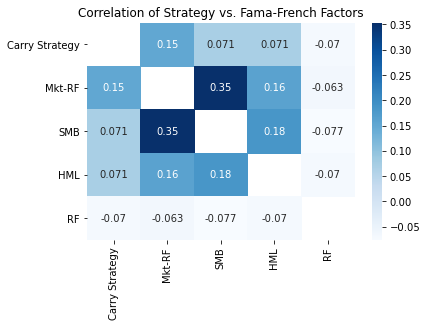

In [49]:
data_spread_FF_comp_alt = pd.concat([results_alt[['Return_WTD']].rename(columns={'Return_WTD':'Carry Strategy'}),FFFactors_Wkly],axis=1)
corr(data_spread_FF_comp_alt)

========================================================================================================================

### Conclusion

========================================================================================================================

In conclusion, the carry trade is a profitable strategy with a reasonable Sharpe/Sortino ratio and with mostly consistent returns throughout time. Returns are negatively skewed, however also have large kurtosis which means there are short periods of high volatility that move against the trade and incur sudden large losses. Despite this dynamic, the analysis shows that over extended periods of time, carry trades pay off.

For all four currencies that were used in the initial strategy of equal investment across available curves, Carry MtM PL outweighed losses on FX depreciation on the local currency. A significant portion of the losses actually came from GBP appreciation vs USD, which hurt the portfolio returns by about \\$2m. Future implementations of this strategy should consider alternative sources of funding - such as JPY which has extremely low interest rates and rather stable FX throughout time. Another consideration would be to consider investing in only relatively high-yielding currencies. Thailand for example, though an EM NDF, barely contributed to returns. The alternative strategy that invested only in the best yields did significantly better in terms of risk metrics as well as absolute PL. A more robust comparison of the pros/cons of even diversification vs max yield should include stress tests for positive correlation environments, which is foregone here.

Other practical considerations to consider would include bid/offer spreads on the borrow and lending rates. Liquidity access and counterparty risk would also be very important given the countries that are being dealt with in this exercise are NDFs. Costs for setting up a custody account or negotiating cash settlement dynamics, given the weekly investment timeframe, would become important factors to include in the analysis as well. 